In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pre_processing as pre_pro
import correlations as corr

# Retrieving data

### Label

In [220]:
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from epigenomic_dataset import active_promoters_vs_inactive_promoters

In [246]:
enhancers, enhancers_labels = active_enhancers_vs_inactive_enhancers(cell_line='A549')
promoters, promoters_labels = active_promoters_vs_inactive_promoters(cell_line='A549')

epigenomes = {
    "promoters": promoters,
    "enhancers": enhancers
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels
}

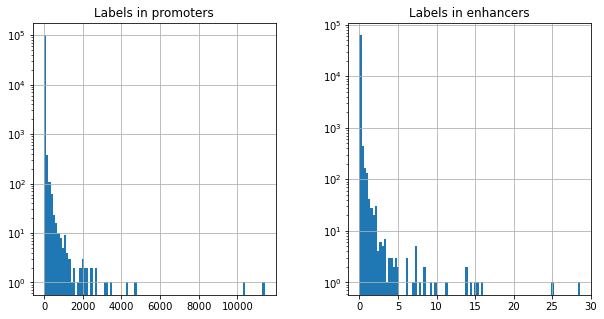

In [4]:
bins = 100
fig, axes = plt.subplots(ncols=len(labels), figsize=(10, 5))

for axis, (region, lbl) in zip(axes, labels.items()):
    lbl.hist(ax = axis, bins = bins, log = True)
    axis.set_title('Labels in ' + region)

In [120]:
print(promoters_labels.describe())
print('-'*20)
print(enhancers_labels.describe())

               A549
count  99881.000000
mean       4.989571
std       68.457689
min        0.000000
25%        0.000000
50%        0.000000
75%        0.553579
max    11402.760776
--------------------
               A549
count  63285.000000
mean       0.025651
std        0.277362
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       28.624352


#### threshold

In [142]:
def threshold_imbalance(dict_labels:dict, pro_thre:int, enh_thre:int) -> tuple:
    
    rate1 = (dict_labels['promoters']['A549']> pro_thre).mean()
    rate2 = (dict_labels['enhancers']['A549']> enh_thre).mean()
    
    return ('promoters_rate: ' + str(rate1),'enhancers_rate: '+ str(rate2))

In [144]:
threshold_imbalance(labels, 5, 0) # Wassmann mess

('promoters_rate: 0.10314273986043392', 'enhancers_rate: 0.05693292249348187')

In [145]:
threshold_imbalance(labels, 1, 1)

('promoters_rate: 0.20401277520249098', 'enhancers_rate: 0.003681757130441653')

#### dropping values between 0 and 1 and binarization

In [ ]:
def drop_01_binarization_1() -> dict:
    labels_drop = {}
    
    for region, data in labels.items():
    
        df = labels[region]
        df_drop = df[(df['A549'] == 0) | (df['A549'] >= 1)] 
        df_drop = df_drop['A549'] > 1
        labels_drop[region] = df_drop
    
    return labels_drop9

In [106]:
labels_drop = drop_01_binarization_1()

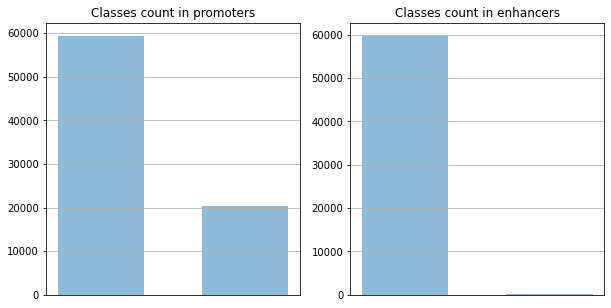

In [138]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, lbl) in zip(axes.ravel(), labels_drop.items()):
    lbl.astype(int).hist(ax=axis, bins=2, alpha=0.5, rwidth=0.6)
    axis.set_title(f"Classes count in {region}")
    axis.set_xticks([])
  

In [151]:
labels_drop['promoters'].mean(), labels_drop['enhancers'].mean()

(0.25547893681043127, 0.003888842526913127)

#### label binarizzate con soglia (1,1)

In [148]:
enhancers, enhancers_labels = active_enhancers_vs_inactive_enhancers(cell_line='A549', binarize = True)
promoters, promoters_labels = active_promoters_vs_inactive_promoters(cell_line='A549', binarize = True)

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels
}

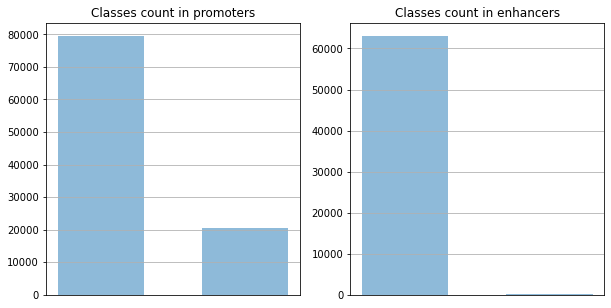

In [149]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, lbl) in zip(axes.ravel(), labels.items()):
    lbl['A549'].astype(int).hist(ax=axis, bins=2, alpha=0.5, rwidth=0.6)
    axis.set_title(f"Classes count in {region}")
    axis.set_xticks([])

Labels of enhancers remain strongly unbalance, even with dropping. Almost all values of enhancers labels are 0 (third quartile is 0).

I decided to set promoters threshold equal to 1 and don't drop values between 0 and 1 because this improve balance between classes but not enough to eliminate samples from the dataset. 
About enhancers the threshold is set to 0 because this leads classes to be as balanced as possible.

I'm not focusing on the biological meaning of my choices, the threshold are chosen to obtain a dataset useful for learning. 

In [258]:
enhancers, enhancers_labels = active_enhancers_vs_inactive_enhancers(cell_line='A549')
promoters, promoters_labels = active_promoters_vs_inactive_promoters(cell_line='A549')

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels
}

#### enhancers

In [259]:
labels['enhancers'] = labels['enhancers'] > 0

In [260]:
labels['enhancers'].mean()

A549    0.056933
dtype: float64

#### promoters

In [261]:
labels['promoters'] = labels['promoters'] > 1

In [262]:
labels['promoters'].mean()

A549    0.204013
dtype: float64

In [263]:
# labels['promoters'].to_csv('./labels/labels_promoters.csv')  
# labels['enhancers'].to_csv('./labels/labels_enhancers.csv')
# d = pd.read_csv('./labels/labels_promoters.csv')

## Pre-processing

In [268]:
enhancers.describe()

chrom,PBX1,HOXB5,CTCF,NR5A2,POLR2AphosphoS2,FOSL2,CBX8,REST,ATAC-seq,JUN,...,HOXB13,DNase-seq,CEBPB,RNF2,MYC,RFX5,CHD2,HOXA7,SIN3A,CHD4
count,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,...,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000
mean,0.958972,0.913036,1.209956,0.973173,0.913585,1.649383,0.784756,0.824127,1.559501,1.128004,...,0.867849,0.409369,1.555871,0.840282,0.963023,0.993750,0.985979,0.778543,1.118602,0.892104
std,1.682574,0.653761,3.790173,0.968981,0.872721,3.299778,0.406876,0.907664,2.136066,0.744430,...,0.558791,1.452805,3.320334,0.715002,0.789865,4.592618,0.828565,0.447260,0.986635,0.520470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.520000,0.420000,0.530000,0.460000,0.520000,0.540000,0.540000,0.470000,0.640000,...,0.510000,0.030000,0.460000,0.440000,0.500000,0.610000,0.590000,0.500000,0.610000,0.550000
50%,0.750000,0.800000,0.630000,0.790000,0.740000,0.810000,0.730000,0.750000,0.820000,1.010000,...,0.780000,0.060000,0.790000,0.720000,0.800000,0.860000,0.890000,0.710000,0.890000,0.810000
75%,1.100000,1.150000,0.900000,1.140000,1.120000,1.290000,0.960000,0.990000,1.530000,1.470000,...,1.100000,0.150000,1.320000,1.070000,1.200000,1.160000,1.250000,0.980000,1.280000,1.130000
max,165.590000,36.510000,101.000000,42.330000,32.560000,82.550000,16.220000,53.750000,20.270000,32.950000,...,13.710000,38.710000,94.530000,31.490000,21.020000,543.970000,81.120000,15.450000,31.220000,11.940000


In [269]:
pre_pro.rate_samples_features(epigenomes)

The rate between samples and features for promoters data is: 2080.8541666666665
--------------------------------------------------------------------------------
The rate between samples and features for enhancers data is: 1318.4375
--------------------------------------------------------------------------------


In [270]:
# NaN values

for region, x in epigenomes.items():
    print("\n".join((
        f"Nan values report for {region} data:\n",
        f"- In the document there are {x.isna().values.sum()} NaN values out of {x.values.size} values.",
        f"  % nan/totale = {x.isna().values.sum()/x.values.size*100}.",
        f"- The sample (row) with most values has {x.isna().sum(axis=1).max()} NaN values out of {x.shape[1]} values.",
        f"- The feature (column) with most values has {x.isna().sum().max()} NaN values out of {x.shape[0]} values.",
        f"- % nan_col_values/tot_samples = {x.isna().sum().max()/x.shape[0]*100}"
    )))
    print("-"*80)

Nan values report for promoters data:

- In the document there are 372 NaN values out of 4794288 values.
  % nan/totale = 0.007759233487850542.
- The sample (row) with most values has 2 NaN values out of 48 values.
- The feature (column) with most values has 189 NaN values out of 99881 values.
- % nan_col_values/tot_samples = 0.18922517796177452
--------------------------------------------------------------------------------
Nan values report for enhancers data:

- In the document there are 32 NaN values out of 3037680 values.
  % nan/totale = 0.0010534355165784414.
- The sample (row) with most values has 1 NaN values out of 48 values.
- The feature (column) with most values has 32 NaN values out of 63285 values.
- % nan_col_values/tot_samples = 0.05056490479576519
--------------------------------------------------------------------------------


In [271]:
# I valori NaN vengono sostituiti tramite KNN

for region, x in epigenomes.items():
    epigenomes[region] = pre_pro.knn_imputer(x)

#### Eliminazione features costanti

In [272]:
for region, x in epigenomes.items():
    result = pre_pro.drop_constant_features(x)
    if x.shape[1] != result.shape[1]:
        print(f"Features in {region} were constant and had to be dropped!")
        epigenomes[region] = result
    else:
        print(f"No constant features were found in {region}!")

No constant features were found in promoters!
No constant features were found in enhancers!


#### Normalizzazione

Usiamo robust_scaler (sottraendo la mediana, non sensibile agli outlier, e dividendo per la sd tra il primo e il terzo quartile, è una versione migliore di z-scoring 

In [273]:
epigenomes = {
    region: pre_pro.robust_zscoring(x)
    for region, x in epigenomes.items()
}

## Correlazione con l'output


se le features non hanno nessun tipo di correlazione con l'output, possiamo pensare di eliminarle

In [274]:
p_value_threshold = 0.01 

# salvo le features non correlate all'interno del dict uncorrelated
uncorrelated = {
    region: set()
    for region in epigenomes
}

#### Correlazione lineare di Pearson

In [275]:
corr.output_correlation('pearson', epigenomes, p_value_threshold, uncorrelated, labels)


Calcolo coefficiente di Pearson per promoters:

La feature EHMT2 non è correlata in modo significativo con l'output, corr: -0.0013886359156064518
La feature FOSB non è correlata in modo significativo con l'output, corr: 0.0003267735569409949
La feature RNF2 non è correlata in modo significativo con l'output, corr: -0.0001342230492837812

Calcolo coefficiente di Pearson per enhancers:

La feature ZC3H11A non è correlata in modo significativo con l'output, corr: 0.008187547698984075
La feature CBX2 non è correlata in modo significativo con l'output, corr: -0.0038494378820642236


#### Correlazione monotona di Spearman

In [276]:
corr.output_correlation('spearman', epigenomes, p_value_threshold, uncorrelated, labels)


Calcolo coefficiente di Pearson per promoters:

La feature ZFP36 non è correlata in modo significativo con l'output, corr: 0.005138431133429463

Calcolo coefficiente di Pearson per enhancers:

La feature CBX2 non è correlata in modo significativo con l'output, corr: -0.0011931716306596745
La feature KDM5A non è correlata in modo significativo con l'output, corr: -0.003784426428309876


In [16]:
# minepy per Windows non vabbene

#### Elimino features non correlate con l'output

In [277]:
for region, x in epigenomes.items():
    epigenomes[region] =x.drop(columns=[
        col
        for col in uncorrelated[region]
        if col in x.columns
    ])

## Correlazione tra features


se le features non hanno nessun tipo di correlazione con l'output, possiamo pensare di eliminarle

In [278]:
correlation_threshold = 0.95

extremely_correlated = {
    region: set()
    for region in epigenomes
}

scores = {
    region: []
    for region in epigenomes
}

#### Correlazione lineare di Pearson

In [279]:
corr.features_correlation(
    'pearson', epigenomes, p_value_threshold, correlation_threshold, extremely_correlated, scores)

Running Pearson test for promoters:   0%|                                                       | 0/44 [00:00<…

Running Pearson test for enhancers:   0%|                                                       | 0/45 [00:00<…

#### Correlazione monotona di Spearman

In [280]:
corr.features_correlation(
    'spearman', epigenomes, p_value_threshold, correlation_threshold, extremely_correlated, scores)

Running Pearson test for promoters:   0%|                                                       | 0/44 [00:00<…

Running Pearson test for enhancers:   0%|                                                       | 0/45 [00:00<…

In [281]:
# non ci sono features altamente correlate
extremely_correlated

{'promoters': set(), 'enhancers': set()}

#### Visualization of the features

In [282]:
# Ordine le correlazioni in modo decrescente
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

Most correlated features from promoters epigenomes


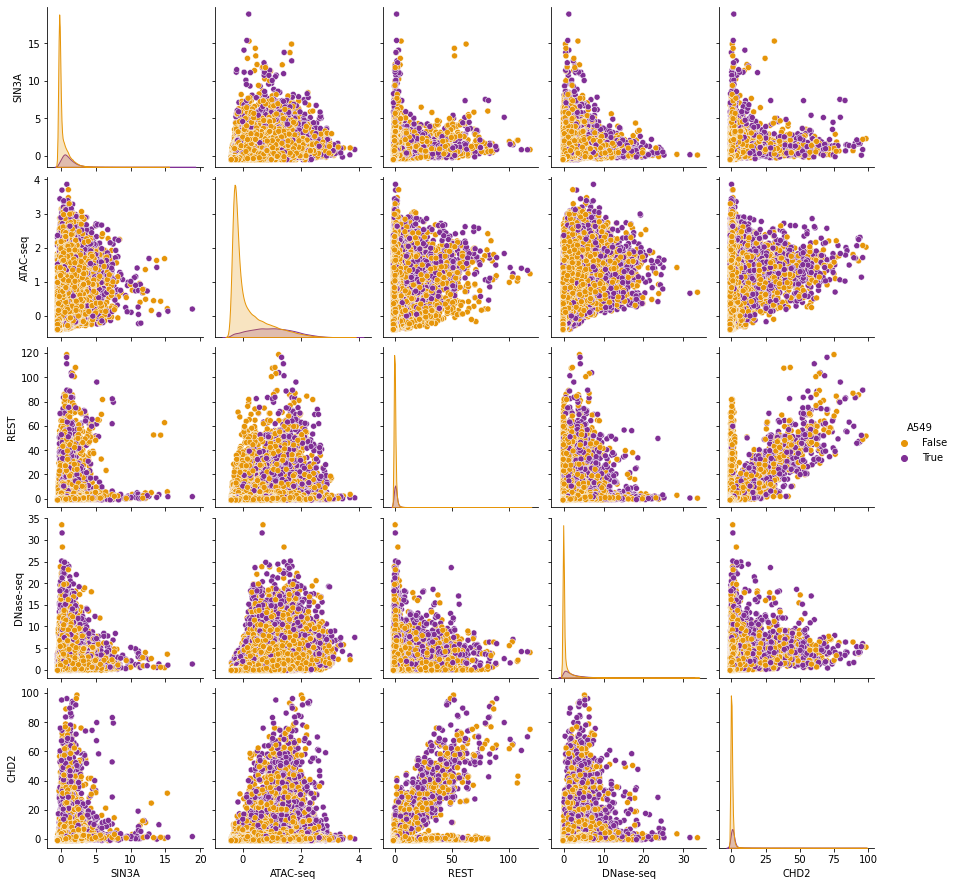

Most correlated features from enhancers epigenomes


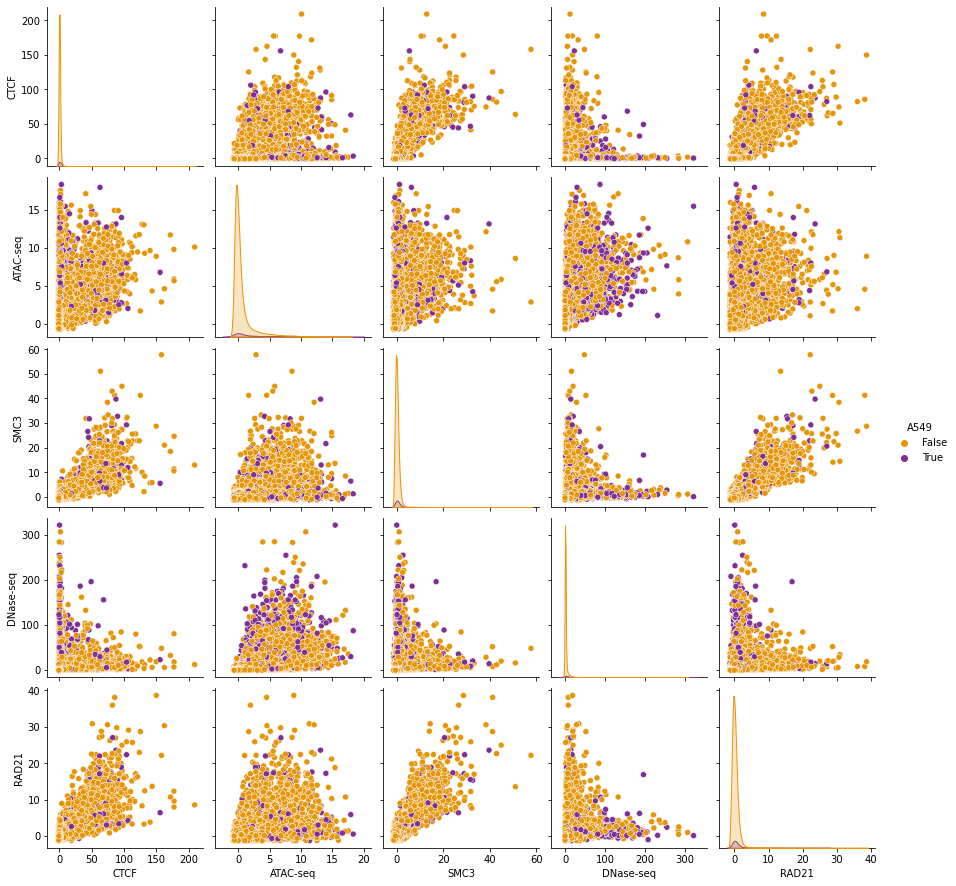

In [283]:
import seaborn as sns
import pandas as pd

for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")
    pairplot = sns.pairplot(pd.concat([
        x[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0], palette = 'CMRmap_r')
    plt.show()
    
    fig = pairplot.fig
    fig.savefig(f"./img/less_correlated_features_{region}.png")

In [ ]:
scores['promoters']